In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)
print(train_images.shape)

(60000, 28, 28, 1)


In [3]:
def create_generator():
    model = tf.keras.Sequential()

    # creating Dense layer with units 7*7*256(batch_size) and input_shape of (100,)
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [4]:
noise_dim = 100
num_of_generated_examples = 16
BATCH_SIZE = 256

seed = tf.random.normal([num_of_generated_examples, noise_dim])
generator = create_generator()
discriminator = create_discriminator()
generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [5]:
@tf.function
def train_step(images, arg, epoch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output)
    
    if arg == 1:
        print("Epoch: {}\nGenerator Loss: {}\nDiscriminator Loss: {}".format(epoch+1, gen_loss, disc_loss))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [6]:
import os

PROJECT_ROOT_DIR = "."
SAVE_ID = "picture"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, SAVE_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=100):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [7]:
import datetime

log_dir = ".\\log"
run_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"/"
train_file_writer = tf.summary.create_file_writer(log_dir+run_name+"/train")
val_file_writer = tf.summary.create_file_writer(log_dir+run_name+"/validation")

Epoch: 1
Generator Loss: 0.8273647427558899
Discriminator Loss: 1.187255620956421
Time for epoch 1 is 18.215118169784546 sec
Epoch: 2
Generator Loss: 0.7930843234062195
Discriminator Loss: 1.4001269340515137
Time for epoch 2 is 17.739461421966553 sec
Epoch: 3
Generator Loss: 0.9320606589317322
Discriminator Loss: 1.1527183055877686
Time for epoch 3 is 18.87909245491028 sec
Epoch: 4
Generator Loss: 0.7616237998008728
Discriminator Loss: 1.3928353786468506
Time for epoch 4 is 18.327718257904053 sec
Epoch: 5
Generator Loss: 0.7574584484100342
Discriminator Loss: 1.3117871284484863
Time for epoch 5 is 18.002837896347046 sec
Generated Images after 5 epochs


ValueError: num must be 1 <= num <= 9, not 10

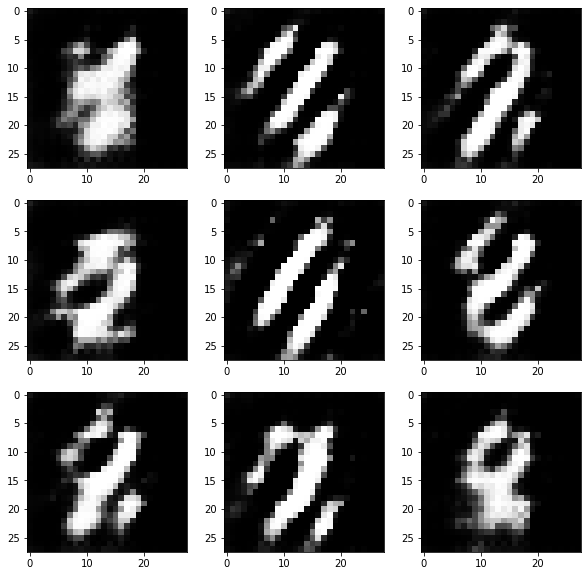

In [9]:
def train_GAN(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        count = 0


        for image_batch in dataset:
            count += 1
            if count == 235:
                train_step(image_batch, 1, epoch)
            else:
                train_step(image_batch, 0, epoch)


        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        generated_images = generator(seed, training=False)
        if (epoch + 1) % 5 == 0:
            print('Generated Images after {} epochs'.format(epoch + 1))
            plt.figure(figsize=(10, 10))
            for i in range(generated_images.shape[0]):
                if i < 10:
                    plt.subplot(3, 3, i + 1)
                    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
                    plt.axis('on')
            save_fig(str(epoch + 1))
            plt.show()


tf.config.run_functions_eagerly(True)
train_GAN(train_dataset, 600)